In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from src.extra.model import ModelDistribution
from src.extra.pprint import print_model
from src.core.core import reset_model

from src.greedy.greedy import greedy_algorithm
from src.greedy.resource_allocation_policy import SumPercentage
from src.greedy.server_selection_policy import SumResources
from src.greedy.task_prioritisation import UtilityDeadlinePerResource

from src.optimal.fixed_optimal import fixed_optimal
from src.core.fixed_task import FixedTask, SumSpeedPowFixedAllocationPriority

In [3]:
def print_results(result, tasks, servers):
    print(f'Social welfare: {result.social_welfare:.3f}, Percentage social welfare: {result.percentage_social_welfare:.3f}, Percentage tasks: {result.percentage_tasks_allocated:.3f}\n')
    # for server in servers:
    #    storage_usage = sum(task.required_storage for task in server.allocated_tasks) / server.storage_capacity
    #    computational_usage = sum(task.compute_speed for task in server.allocated_tasks) / server.computation_capacity
    #    bandwidth_usage = sum(task.loading_speed + task.sending_speed for task in server.allocated_tasks) / server.bandwidth_capacity
    #    print(f'{server.name} resouce usage - Stor: {storage_usage:.3f}, Comp: {computational_usage:.3f}, Band: {bandwidth_usage:.3f}')
    print(f'Server avg storage: {np.mean([sum(task.required_storage for task in server.allocated_tasks) / server.storage_capacity for server in servers]):3.2f}, '
          f'computation: {np.mean([sum(task.compute_speed for task in server.allocated_tasks) / server.computation_capacity for server in servers]):3.2f}, '
          f'bandwidth: {np.mean([sum(task.loading_speed + task.sending_speed for task in server.allocated_tasks) / server.bandwidth_capacity for server in servers]):3.2f}')
    
    avg_loading_speed = np.mean([task.loading_speed for task in tasks if task.running_server])
    avg_compute_speed = np.mean([task.compute_speed for task in tasks if task.running_server])
    avg_sending_speed = np.mean([task.sending_speed for task in tasks if task.running_server])
    print(f'\nTask avg loading speed: {avg_loading_speed:3.2f}, compute speed: {avg_compute_speed:3.2f}, sending speed: {avg_sending_speed:3.2f}')
    avg_loading_time = np.mean([task.required_storage / task.loading_speed for task in tasks if task.running_server])
    avg_compute_time = np.mean([task.required_computation / task.compute_speed for task in tasks if task.running_server])
    avg_sending_time = np.mean([task.required_results_data / task.sending_speed for task in tasks if task.running_server])
    print(f'Task avg loading time: {avg_loading_time:3.2f}, compute time: {avg_compute_time:3.2f}, sending time: {avg_sending_time:3.2f}')
    

def avg_resource(tasks, attribute):
    return np.mean([getattr(task, attribute) for task in tasks])

In [17]:
alibaba_model = ModelDistribution('../alibaba.mdl', num_tasks=40, num_servers=10)

In [18]:
tasks, servers = alibaba_model.generate()
print('Tasks - ' + ', '.join([f"{var}: {avg_resource(tasks, var):3.2f}" for var in ["required_storage", "required_computation", "required_results_data"]]))

fixed_tasks = [FixedTask(task, SumSpeedPowFixedAllocationPriority()) for task in tasks]
print('\nFixed tasks - ' + ', '.join([f"{var}: {avg_resource(fixed_tasks, var):3.2f}" for var in ["required_storage", "required_computation", "required_results_data"]]))
print('Fixed tasks - ' + ', '.join([f"{var}: {avg_resource(fixed_tasks, var):3.2f}" for var in ["loading_speed", "compute_speed", "sending_speed"]]))

foreknowledge_fixed_tasks = [FixedTask(task, SumSpeedPowFixedAllocationPriority(), resource_foreknowledge=True) for task in tasks]
print('\nForeknowledge fixed tasks - ' + ', '.join([f"{var}: {avg_resource(foreknowledge_fixed_tasks, var):3.2f}" for var in ["required_storage", "required_computation", "required_results_data"]]))
print('Foreknowledge fixed tasks - ' + ', '.join([f"{var}: {avg_resource(foreknowledge_fixed_tasks, var):3.2f}" for var in ["loading_speed", "compute_speed", "sending_speed"]]))

# fig, axs = plt.subplots(1, 4, figsize=(15, 4))
# for ax, var in zip(axs.flatten(), ['required_storage', 'required_computation', 'required_results_data', 'deadline']):
#     ax.hist([getattr(task, var) for task in tasks], bins=20)
#     ax.set_title(var)

Tasks - required_storage: 52.00, required_computation: 1617.35, required_results_data: 17.95

Fixed tasks - required_storage: 149.62, required_computation: 4061.25, required_results_data: 17.95
Fixed tasks - loading_speed: 45.45, compute_speed: 72.50, sending_speed: 9.35

Foreknowledge fixed tasks - required_storage: 52.00, required_computation: 1617.35, required_results_data: 17.95
Foreknowledge fixed tasks - loading_speed: 12.03, compute_speed: 23.10, sending_speed: 9.35


In [19]:
result = greedy_algorithm(tasks, servers, UtilityDeadlinePerResource(), SumResources(), SumPercentage())
print_results(result, tasks, servers)

Social welfare: 387.200, Percentage social welfare: 0.867, Percentage tasks: 0.800

Server avg storage: 0.44, computation: 0.89, bandwidth: 0.87

Task avg loading speed: 5.16, compute speed: 18.75, sending speed: 3.03
Task avg loading time: 12.14, compute time: 36.27, sending time: 6.15


In [20]:
reset_model(tasks, servers)
result = fixed_optimal(fixed_tasks, servers, time_limit=4)
print_results(result, fixed_tasks, servers)

Social welfare: 117.650, Percentage social welfare: 0.263, Percentage tasks: 0.175

Server avg storage: 0.19, computation: 0.49, bandwidth: 0.29

Task avg loading speed: 10.29, compute speed: 50.00, sending speed: 3.43
Task avg loading time: 16.16, compute time: 100.00, sending time: 7.50


In [21]:
reset_model(tasks, servers)
result = fixed_optimal(foreknowledge_fixed_tasks, servers, time_limit=4)
print_results(result, foreknowledge_fixed_tasks, servers)

Social welfare: 298.420, Percentage social welfare: 0.668, Percentage tasks: 0.650

Server avg storage: 0.31, computation: 0.45, bandwidth: 0.99

Task avg loading speed: 6.50, compute speed: 11.23, sending speed: 5.15
Task avg loading time: 10.17, compute time: 48.87, sending time: 4.29


(array([92., 82., 74., 73., 61., 54., 50., 44., 41., 36., 40., 36., 25.,
        23., 21., 27., 16., 25., 12., 12., 13., 14., 13.,  8., 20., 11.,
         6., 10.,  7.,  6.,  9.,  3.,  4.,  2.,  6.,  2.,  4.,  4.,  0.,
         1.,  4.,  2.,  1.,  0.,  1.,  2.,  0.,  1.,  0.,  2.]),
 array([ 0.17 ,  1.202,  2.234,  3.266,  4.298,  5.33 ,  6.362,  7.394,
         8.426,  9.458, 10.49 , 11.522, 12.554, 13.586, 14.618, 15.65 ,
        16.682, 17.714, 18.746, 19.778, 20.81 , 21.842, 22.874, 23.906,
        24.938, 25.97 , 27.002, 28.034, 29.066, 30.098, 31.13 , 32.162,
        33.194, 34.226, 35.258, 36.29 , 37.322, 38.354, 39.386, 40.418,
        41.45 , 42.482, 43.514, 44.546, 45.578, 46.61 , 47.642, 48.674,
        49.706, 50.738, 51.77 ]),
 <BarContainer object of 50 artists>)

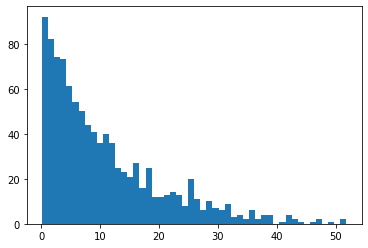

In [23]:
alibaba_model = ModelDistribution('../alibaba.mdl', num_tasks=1000, num_servers=10)
tasks, servers = alibaba_model.generate()

fig, ax = plt.subplots()
ax.hist([task.value for task in tasks], bins=50)